In [1]:
!pip install tf2crf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 4.8 MB/s 


In [2]:
pip install -U 'scikit-learn<0.24'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.8 MB 5.1 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.5 requires scikit-learn>=1.0.0, but you have scikit-learn 0.23.2 which is incompatible.
imbalanced-learn 0.8.1 requires scikit-learn>=0.24, but you have scikit-learn 0.23.2 which is incompatible.


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from itertools import chain
import numpy as np

import nltk
import sklearn
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from nltk.tokenize import word_tokenize
import numpy as np

import keras 
from tf2crf import CRF 
from tf2crf import ModelWithCRFLoss

from keras.models import Sequential,Model
from keras.layers import LSTM,Bidirectional,Dense,Input,Embedding,TimeDistributed
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [4]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [6]:
from google.colab import drive,files
drive.mount("/content/drive")
dataM='/content/drive/My Drive/Colab Notebooks/MODELS/'
filepath = dataM+'BiLSTM_CRF.ml'

Mounted at /content/drive


In [24]:
!cp -rf drive/MyDrive/job_20k.json /content/

In [27]:
import pandas as pd
import json
path_to_json = 'job_20k.json'
df  = pd.read_json(path_to_json,lines=True)
df.head().T

,0,1,2,3,4
clean_descrition,A technology services client of ours is lookin...,Job Title :Java Sr developerLocation: RemoteLo...,Mandatory Skills: Strong in Oracle database 19...,"Associate Scientist Thousand Oaks, CADescripti...","Growing fintech company looking for Mid Level,..."
organization_list,"[Swift, Strategic, Solutions, Inc]","[AQUA, Information, Systems,, Inc.]","[Softnet, Consulting, Inc]","[Apex, Systems]",[Jobot]
skill_list,"[NoSQL, Teradata, Netezza, Cosmos, DB, JSON, A...","[Java, JEE, J2EE]","[Oracle, database, 19c, Advanced, PL/SQL, prog...","[Biochemistry, Biology, Analytical, Systems]","[Developer, JavaScript, SQL, ASP, HTML, Archit..."
job_title_list,"[Bigdata, Engineer]","[Java, developer]","[Oracle, PL/SQL, Lead, Architect]","[Associate, Scientist]","[Software, Engineer]"


In [29]:
df['clean_descrition'] = df['clean_descrition'].str.replace(r'[^\w\s]+', ' ')
df['clean_descrition'] = df['clean_descrition'].apply(lambda x: ' '.join(x.split()[:128]))
df['clean_descrition'][1]

<ipython-input-29-42c4f31900d0>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['clean_descrition'] = df['clean_descrition'].str.replace(r'[^\w\s]+', ' ')


'Job Title Java Sr developerLocation RemoteLong TermSkills java jeShould have good understanding on the change management role and had depth knowledge on the change advisory board process CAB Good knowledge on the incident management Problem management Change Management Should have involved in the 3L level of activities i e root cause analysis environment analysis understanding the application architecture infrastructure architecture The resource should have very good understanding on the SDLC process Very good knowledge on the Java J2EE and have hands on experience in understanding the architecture of heterogeneous application Good communication skills and team handling abilities Should have worked on the onshore offshore model Should be flexible and having good attitude'

In [30]:
jobs = list(df.clean_descrition)
def convert_to_list_then_dict(df_column= None, key_value=str):
    value_list = list(df_column)
    _ = list(set([item for value_list in value_list for item in value_list]))
    return dict.fromkeys(_, key_value)

org = convert_to_list_then_dict(df_column=df.organization_list, key_value='C')
skill = convert_to_list_then_dict(df_column=df.skill_list, key_value='S')
job = convert_to_list_then_dict(df_column=df.job_title_list, key_value='J')    

In [41]:
XTr= jobs[:15000]
XVal= jobs[15000:20000]
org_b = org
skills_b = skill
jobs_b = job

In [42]:
def make(X,org_b,skills_b,jobs_b):
  big=[]
  for sentence in X:
    token=word_tokenize(sentence)
    small=[]
    token_t=nltk.pos_tag(token)
    for f,s in token_t:
      tag='O'
      if f.lower() in org_b:
        tag=org_b[f.lower()]
      if f.lower() in skills_b:
        tag=skills_b[f.lower()]
      if f.lower() in jobs_b:
        tag=jobs_b[f.lower()]
      small.append((f,s,tag))
    big.append(small)
  return big
XTr_=make(XTr,org_b,skills_b,jobs_b)
XVal_=make(XVal,org_b,skills_b,jobs_b)

In [46]:
msgLen=128

def fixMsg(X):
  global msgLen
  Xc=[]
  for i in range(len(X)):
    if len(X[i])<msgLen:
      while len(X[i])<msgLen:
        X[i].append(('UNK','UNK','UNK'))
    elif len(X[i])>msgLen:
      temp=X[i]
      del X[i]
      lb=0;chunk=msgLen
      while lb<len(temp):
        split=[]
        for j in range(lb,lb+chunk):
          if j<len(temp):
            split.append(temp[j])
          else:
            split.append(('UNK','UNK','UNK'))
        X.append(split)
        #print(X)
        lb+=chunk
  return X 

XTr_t=fixMsg(XTr_)
XVal_t=fixMsg(XVal_)

In [47]:
for x in XTr_t:
  assert(len(x)==msgLen)
print(XTr_t[0])
for x in XVal_t:
  assert(len(x)==msgLen)
print(XVal_t[0])

[('A', 'DT', 'J'), ('technology', 'NN', 'J'), ('services', 'NNS', 'J'), ('client', 'NN', 'J'), ('of', 'IN', 'J'), ('ours', 'NN', 'O'), ('is', 'VBZ', 'J'), ('looking', 'VBG', 'J'), ('For', 'IN', 'J'), ('Bigdata', 'NNP', 'S'), ('Engineer', 'NNP', 'J'), ('on', 'IN', 'J'), ('their', 'PRP$', 'S'), ('ongoing', 'JJ', 'O'), ('projects', 'NNS', 'J'), ('This', 'DT', 'S'), ('is', 'VBZ', 'J'), ('going', 'VBG', 'O'), ('to', 'TO', 'J'), ('be', 'VB', 'J'), ('an', 'DT', 'J'), ('Onsite', 'NNP', 'J'), ('position', 'NN', 'J'), ('Below', 'NNP', 'J'), ('are', 'VBP', 'J'), ('the', 'DT', 'J'), ('required', 'JJ', 'J'), ('skills', 'NNS', 'J'), ('for', 'IN', 'J'), ('this', 'DT', 'S'), ('role', 'NN', 'J'), ('Required', 'NNP', 'J'), ('Skills', 'NNP', 'J'), ('Strong', 'NNP', 'J'), ('experience', 'NN', 'J'), ('building', 'NN', 'J'), ('and', 'CC', 'J'), ('optimizing', 'VBG', 'O'), ('big', 'JJ', 'S'), ('data', 'NNS', 'J'), ('pipelines', 'NNS', 'S'), ('architectures', 'NNS', 'S'), ('and', 'CC', 'J'), ('data', 'NNS', '

In [10]:
dict_={}
dict_1={}
token=1;token1=0
for x in XTr_t:
  for a,b,c in x:
    if a not in dict_:
      dict_[a]=token
      token=token+1
    if c not in dict_1:
      if c=='K':
        print(a,b,c)
      dict_1[c]=token1
      token1=token1+1
for x in XVal_t:
  for a,b,c in x:
    if a not in dict_:
      dict_[a]=token
      token=token+1
    if c not in dict_1:
      dict_1[c]=token1
      token1=token1+1
print('No of tokens words[{}] labels[{}]'.format(token,token1))

No of tokens words[26] labels[5]


In [11]:
XTr_fin=np.array([[dict_[element[0]] for element in sentence] for sentence in XTr_t])
XVal_fin=np.array([[dict_[element[0]] for element in sentence] for sentence in XVal_t])

yTr=np.array([[dict_1[element[2]] for element in sentence] for sentence in XTr_t])
yVal=np.array([[dict_1[element[2]] for element in sentence] for sentence in XVal_t])

In [12]:
embedding_dim = 100
input=Input(shape=(msgLen,))
mo=Embedding(input_dim=token,output_dim=embedding_dim)(input)
frwd=LSTM(64,return_sequences=True)
back=LSTM(64,return_sequences=True,go_backwards=True)
mo=Bidirectional(frwd,backward_layer=back)(mo)
mo=TimeDistributed(Dense(32,activation='relu'))(mo)
output=CRF(units=token1)(mo)
mo=Model(input,output)
mo.summary()

model=ModelWithCRFLoss(mo, sparse_target=True)
model.compile(optimizer ='rmsprop')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10)]              0         
                                                                 
 embedding (Embedding)       (None, 10, 100)           2600      
                                                                 
 bidirectional (Bidirectiona  (None, 10, 128)          84480     
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 10, 32)           4128      
 ibuted)                                                         
                                                                 
 crf (CRF)                   ((None, 10),              190       
                              (None, 10, 5),                     
                              (None,),                       

In [13]:
es = EarlyStopping(monitor = "val_loss_val", mode = "min", verbose = True, restore_best_weights=True, patience = 1)
cp = ModelCheckpoint(filepath,monitor="val_loss_val",mode = "min",verbose=True,save_best_only=True)

# history = model.fit(XTr_fin,yTr,validation_data=[XVal_fin,yVal],epochs=2,batch_size=1,callbacks=[cp,es])
history = model.fit(XTr_fin,yTr,epochs=10,validation_data=[XVal_fin,yVal],batch_size=1)

Epoch 1/10
3/3 [==============================] - 9s 871ms/step - loss: 15.5487 - accuracy: 0.5000 - val_loss_val: 13.9902 - val_val_accuracy: 0.3000
Epoch 2/10
3/3 [==============================] - 0s 22ms/step - loss: 14.9890 - accuracy: 0.5667 - val_loss_val: 13.7909 - val_val_accuracy: 0.3000
Epoch 3/10
3/3 [==============================] - 0s 26ms/step - loss: 14.2022 - accuracy: 0.5667 - val_loss_val: 13.6508 - val_val_accuracy: 0.3000
Epoch 4/10
3/3 [==============================] - 0s 25ms/step - loss: 13.1309 - accuracy: 0.6000 - val_loss_val: 13.6264 - val_val_accuracy: 0.3000
Epoch 5/10
3/3 [==============================] - 0s 26ms/step - loss: 12.0511 - accuracy: 0.6000 - val_loss_val: 13.8177 - val_val_accuracy: 0.3000
Epoch 6/10
3/3 [==============================] - 0s 24ms/step - loss: 11.2523 - accuracy: 0.6000 - val_loss_val: 14.1528 - val_val_accuracy: 0.3000
Epoch 7/10
3/3 [==============================] - 0s 25ms/step - loss: 10.7803 - accuracy: 0.6000 - val_l

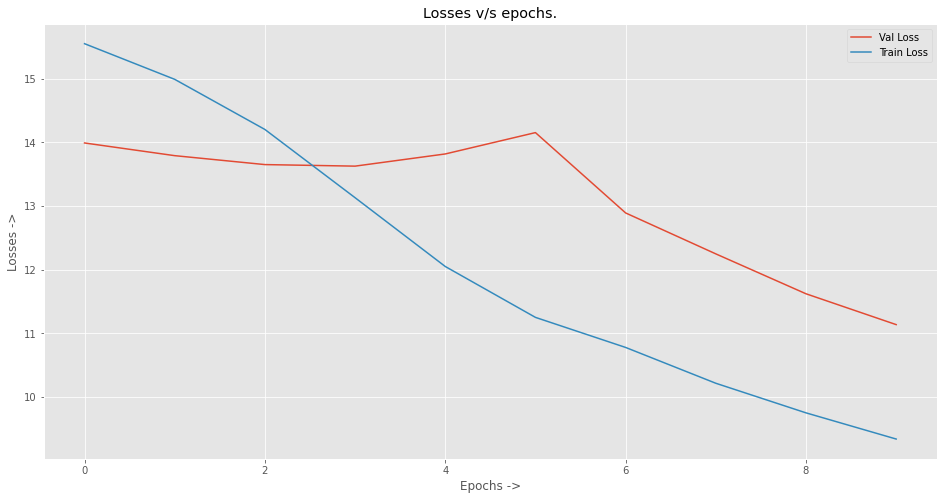

In [14]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (16,8)
plt.plot(history.history['val_loss_val'])
plt.plot(history.history['loss'])
plt.xlabel('Epochs ->')
plt.ylabel('Losses ->')
plt.title('Losses v/s epochs.')
plt.legend(['Val Loss','Train Loss'])
plt.show()

In [15]:
dict_1R={}
for k,v in dict_1.items():
  dict_1R[v]=k

In [16]:
labels_=model.predict(XVal_fin)
i=0 # i-th example from val dataset.
cnt=0
print()
for x in XVal_[0]:
  print('{} {}'.format(x[0],dict_1R[labels_[i][cnt]]))
  cnt+=1

1/1 [==============================] - 1s 1s/step

Amazon O
is O
looking O
for O
DevOps O
engineer O
UNK O
UNK S
UNK UNK
UNK UNK


In [17]:
dict_1

{'C': 0, 'O': 1, 'J': 2, 'S': 3, 'UNK': 4}

In [18]:
!pip install sklearn-crfsuite

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 5.0 MB/s 


In [19]:
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

def labelIt(yVal):
  yVal_lis=[]
  for y1 in yVal:
    temp=[]
    for y2 in y1:
      temp.append(dict_1R[y2])
    yVal_lis.append(temp)
  return yVal_lis 

yVal_=labelIt(yVal)
yPred_=labelIt(labels_)
labls=['C','J','S','O','UNK']
metrics.flat_f1_score(yVal_,yPred_,average='weighted',labels=labls)

0.44666666666666666

In [20]:
print(metrics.flat_classification_report(yVal_,yPred_,labels=labls,digits=3))

              precision    recall  f1-score   support

           C      0.000     0.000     0.000         1
           J      0.000     0.000     0.000         2
           S      0.000     0.000     0.000         0
           O      0.429     1.000     0.600         3
         UNK      1.000     0.500     0.667         4

    accuracy                          0.500        10
   macro avg      0.286     0.300     0.253        10
weighted avg      0.529     0.500     0.447        10



/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=['C', 'J', 'S', 'O', 'UNK'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
